# Deep Convolutional GANs

In this notebook, I'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

I'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: data: File exists


## Getting the data

Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

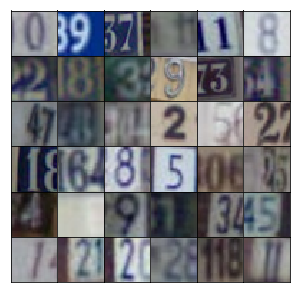

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), self.scaler(y)

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

The input will be our noise vector `z`. The output will be a $tanh$ output with size 32x32 which is the size of our SVHN images.

We'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically we'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now        
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here we'll build the discriminator. This is basically just a convolutional classifier. The input to the discriminator are 32x32x3 tensors/images. The discriminator contains a few convolutional layers, then a fully connected layer for the output. 

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers



In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, 0.5)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an errror without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

            saver.save(sess, './checkpoints/generator.ckpt')


    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0003
batch_size = 128
epochs = 10
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/10... Discriminator Loss: 2.0954... Generator Loss: 0.1996
Epoch 1/10... Discriminator Loss: 0.2208... Generator Loss: 2.4744
Epoch 1/10... Discriminator Loss: 0.0835... Generator Loss: 3.8436
Epoch 1/10... Discriminator Loss: 0.1718... Generator Loss: 2.4521
Epoch 1/10... Discriminator Loss: 0.0892... Generator Loss: 4.0654
Epoch 1/10... Discriminator Loss: 0.2038... Generator Loss: 2.8066
Epoch 1/10... Discriminator Loss: 0.9151... Generator Loss: 1.5787
Epoch 1/10... Discriminator Loss: 1.1804... Generator Loss: 0.5546
Epoch 1/10... Discriminator Loss: 0.9876... Generator Loss: 1.2351
Epoch 1/10... Discriminator Loss: 0.4189... Generator Loss: 2.0109


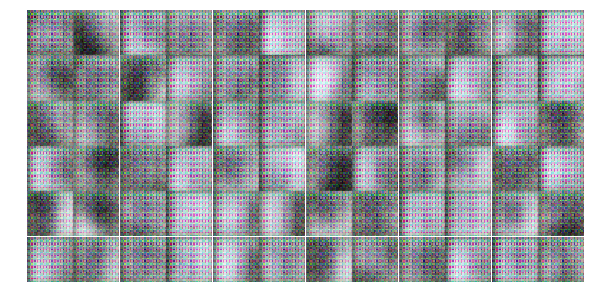

Epoch 1/10... Discriminator Loss: 0.5164... Generator Loss: 1.4812
Epoch 1/10... Discriminator Loss: 0.3654... Generator Loss: 2.8254
Epoch 1/10... Discriminator Loss: 0.3331... Generator Loss: 1.9094
Epoch 1/10... Discriminator Loss: 0.2446... Generator Loss: 2.3224
Epoch 1/10... Discriminator Loss: 0.5878... Generator Loss: 2.7778
Epoch 1/10... Discriminator Loss: 0.7011... Generator Loss: 0.9315
Epoch 1/10... Discriminator Loss: 0.3387... Generator Loss: 1.9328
Epoch 1/10... Discriminator Loss: 1.1667... Generator Loss: 3.8534
Epoch 1/10... Discriminator Loss: 1.3353... Generator Loss: 0.5026
Epoch 1/10... Discriminator Loss: 1.9373... Generator Loss: 0.7910


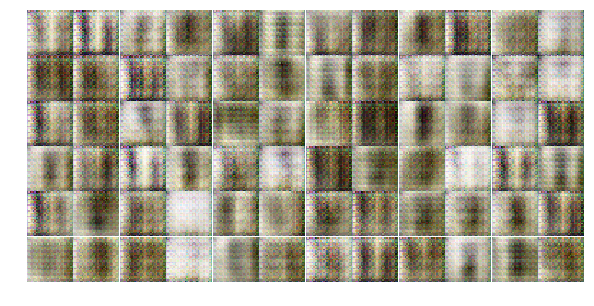

Epoch 1/10... Discriminator Loss: 0.6628... Generator Loss: 1.3960
Epoch 1/10... Discriminator Loss: 0.7456... Generator Loss: 1.2130
Epoch 1/10... Discriminator Loss: 1.7592... Generator Loss: 0.5943
Epoch 1/10... Discriminator Loss: 1.1436... Generator Loss: 1.0052
Epoch 1/10... Discriminator Loss: 0.7106... Generator Loss: 1.3957
Epoch 1/10... Discriminator Loss: 0.8614... Generator Loss: 1.8733
Epoch 1/10... Discriminator Loss: 1.1152... Generator Loss: 2.0446
Epoch 1/10... Discriminator Loss: 0.5251... Generator Loss: 1.1191
Epoch 1/10... Discriminator Loss: 1.1015... Generator Loss: 1.2522
Epoch 1/10... Discriminator Loss: 0.9782... Generator Loss: 1.1931


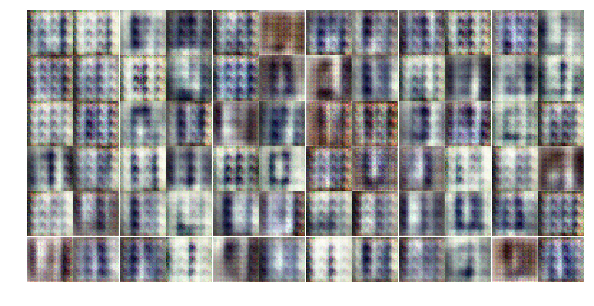

Epoch 1/10... Discriminator Loss: 0.9755... Generator Loss: 1.0060
Epoch 1/10... Discriminator Loss: 0.6801... Generator Loss: 3.1537
Epoch 1/10... Discriminator Loss: 0.4293... Generator Loss: 2.6895
Epoch 1/10... Discriminator Loss: 1.3004... Generator Loss: 1.0537
Epoch 1/10... Discriminator Loss: 1.9199... Generator Loss: 0.6167
Epoch 1/10... Discriminator Loss: 1.3712... Generator Loss: 0.8991
Epoch 1/10... Discriminator Loss: 1.0474... Generator Loss: 0.8620
Epoch 1/10... Discriminator Loss: 1.1214... Generator Loss: 0.7733
Epoch 1/10... Discriminator Loss: 0.7320... Generator Loss: 1.7075
Epoch 1/10... Discriminator Loss: 0.9875... Generator Loss: 1.2213


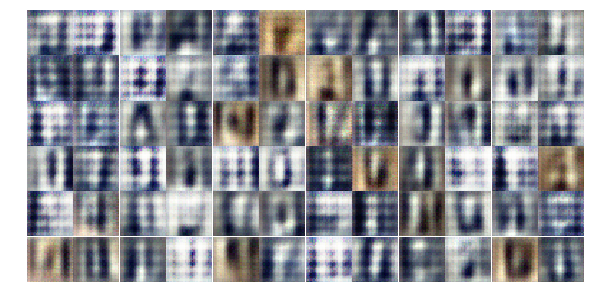

Epoch 1/10... Discriminator Loss: 0.6749... Generator Loss: 1.7307
Epoch 1/10... Discriminator Loss: 1.2058... Generator Loss: 0.6380
Epoch 1/10... Discriminator Loss: 0.7058... Generator Loss: 1.2019
Epoch 1/10... Discriminator Loss: 2.2046... Generator Loss: 0.2954
Epoch 1/10... Discriminator Loss: 0.9446... Generator Loss: 1.1201
Epoch 1/10... Discriminator Loss: 1.0109... Generator Loss: 1.2134
Epoch 1/10... Discriminator Loss: 1.2580... Generator Loss: 0.8443
Epoch 1/10... Discriminator Loss: 0.8010... Generator Loss: 1.1902
Epoch 1/10... Discriminator Loss: 0.8437... Generator Loss: 1.0329
Epoch 1/10... Discriminator Loss: 1.0394... Generator Loss: 0.9085


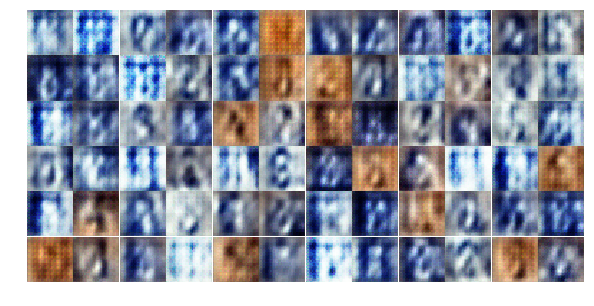

Epoch 1/10... Discriminator Loss: 1.3456... Generator Loss: 0.7747
Epoch 1/10... Discriminator Loss: 1.0612... Generator Loss: 1.2043
Epoch 1/10... Discriminator Loss: 1.0278... Generator Loss: 1.0017
Epoch 1/10... Discriminator Loss: 1.1762... Generator Loss: 0.7807
Epoch 1/10... Discriminator Loss: 0.8783... Generator Loss: 1.2426
Epoch 1/10... Discriminator Loss: 0.6944... Generator Loss: 1.2102
Epoch 1/10... Discriminator Loss: 0.8137... Generator Loss: 1.2393
Epoch 2/10... Discriminator Loss: 0.8473... Generator Loss: 1.1122
Epoch 2/10... Discriminator Loss: 0.8524... Generator Loss: 1.1831
Epoch 2/10... Discriminator Loss: 1.0746... Generator Loss: 0.8730


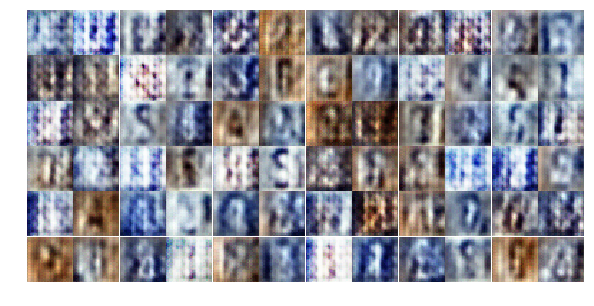

Epoch 2/10... Discriminator Loss: 0.9819... Generator Loss: 1.1856
Epoch 2/10... Discriminator Loss: 1.2013... Generator Loss: 1.0086
Epoch 2/10... Discriminator Loss: 1.0559... Generator Loss: 1.1455
Epoch 2/10... Discriminator Loss: 1.1713... Generator Loss: 1.7832
Epoch 2/10... Discriminator Loss: 1.0912... Generator Loss: 0.7584
Epoch 2/10... Discriminator Loss: 1.1037... Generator Loss: 1.1518
Epoch 2/10... Discriminator Loss: 1.5441... Generator Loss: 0.5327
Epoch 2/10... Discriminator Loss: 0.8289... Generator Loss: 1.5097
Epoch 2/10... Discriminator Loss: 1.0199... Generator Loss: 1.1734
Epoch 2/10... Discriminator Loss: 0.9759... Generator Loss: 1.1088


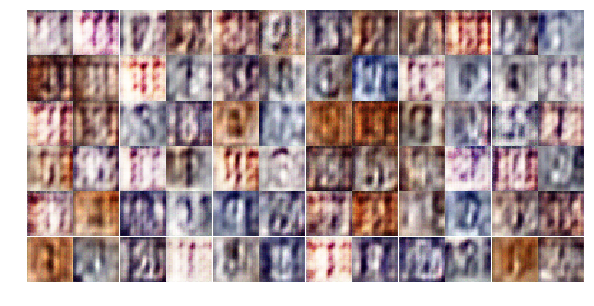

Epoch 2/10... Discriminator Loss: 1.1496... Generator Loss: 0.9051
Epoch 2/10... Discriminator Loss: 1.2818... Generator Loss: 0.9950
Epoch 2/10... Discriminator Loss: 1.2783... Generator Loss: 0.8818
Epoch 2/10... Discriminator Loss: 1.2022... Generator Loss: 0.7758
Epoch 2/10... Discriminator Loss: 1.1244... Generator Loss: 1.1509
Epoch 2/10... Discriminator Loss: 1.3595... Generator Loss: 0.9383
Epoch 2/10... Discriminator Loss: 1.2322... Generator Loss: 0.7831
Epoch 2/10... Discriminator Loss: 1.3281... Generator Loss: 0.8115
Epoch 2/10... Discriminator Loss: 1.2316... Generator Loss: 0.8690
Epoch 2/10... Discriminator Loss: 1.3856... Generator Loss: 0.6717


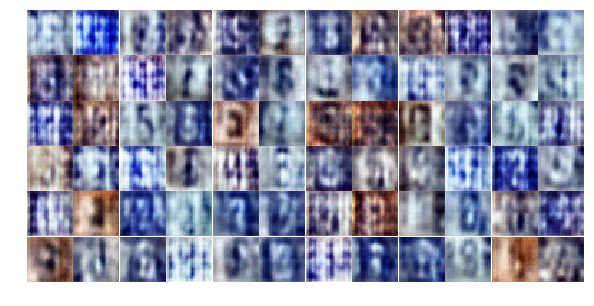

Epoch 2/10... Discriminator Loss: 1.2410... Generator Loss: 0.7102
Epoch 2/10... Discriminator Loss: 1.3590... Generator Loss: 0.7616
Epoch 2/10... Discriminator Loss: 1.0333... Generator Loss: 1.3155
Epoch 2/10... Discriminator Loss: 0.9763... Generator Loss: 1.0301
Epoch 2/10... Discriminator Loss: 1.3421... Generator Loss: 0.9539
Epoch 2/10... Discriminator Loss: 1.1321... Generator Loss: 0.8957
Epoch 2/10... Discriminator Loss: 1.2623... Generator Loss: 0.5884
Epoch 2/10... Discriminator Loss: 1.2101... Generator Loss: 0.7339
Epoch 2/10... Discriminator Loss: 1.2666... Generator Loss: 0.6838
Epoch 2/10... Discriminator Loss: 0.9042... Generator Loss: 1.0285


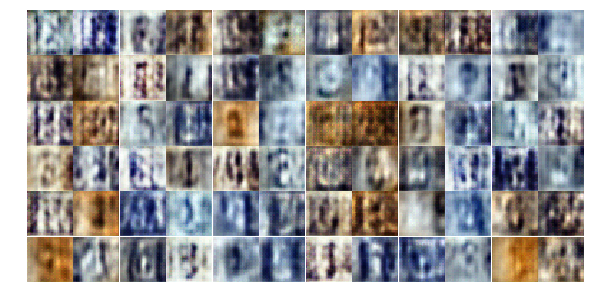

Epoch 2/10... Discriminator Loss: 1.1863... Generator Loss: 0.7250
Epoch 2/10... Discriminator Loss: 1.0173... Generator Loss: 1.2972
Epoch 2/10... Discriminator Loss: 1.2585... Generator Loss: 0.8463
Epoch 2/10... Discriminator Loss: 1.4084... Generator Loss: 0.5170
Epoch 2/10... Discriminator Loss: 0.9463... Generator Loss: 1.1429
Epoch 2/10... Discriminator Loss: 0.9675... Generator Loss: 1.1518
Epoch 2/10... Discriminator Loss: 1.2070... Generator Loss: 0.8919
Epoch 2/10... Discriminator Loss: 1.1995... Generator Loss: 1.0726
Epoch 2/10... Discriminator Loss: 1.0625... Generator Loss: 0.9152
Epoch 2/10... Discriminator Loss: 1.1977... Generator Loss: 0.8667


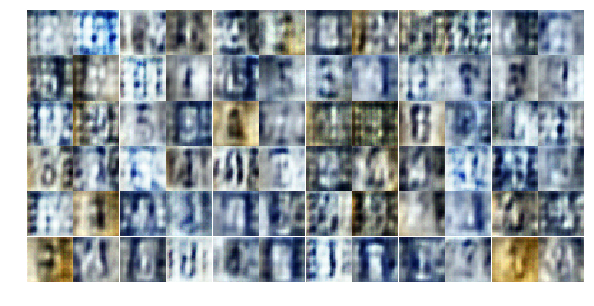

Epoch 2/10... Discriminator Loss: 0.5834... Generator Loss: 1.6530
Epoch 2/10... Discriminator Loss: 1.2034... Generator Loss: 0.9223
Epoch 2/10... Discriminator Loss: 0.9000... Generator Loss: 1.1362
Epoch 2/10... Discriminator Loss: 1.2860... Generator Loss: 0.6085
Epoch 2/10... Discriminator Loss: 1.0802... Generator Loss: 1.0817
Epoch 2/10... Discriminator Loss: 1.0563... Generator Loss: 0.7394
Epoch 2/10... Discriminator Loss: 1.1556... Generator Loss: 1.6451
Epoch 2/10... Discriminator Loss: 1.0102... Generator Loss: 1.4123
Epoch 2/10... Discriminator Loss: 0.9726... Generator Loss: 1.1005
Epoch 2/10... Discriminator Loss: 0.8164... Generator Loss: 1.5208


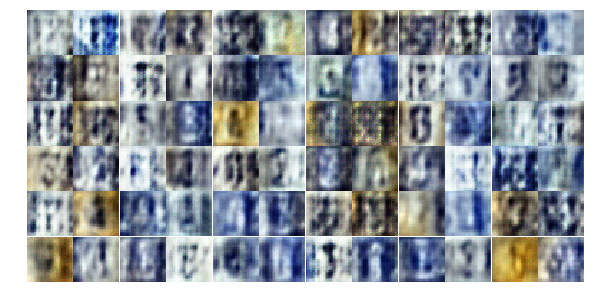

Epoch 2/10... Discriminator Loss: 1.0837... Generator Loss: 1.0794
Epoch 2/10... Discriminator Loss: 0.9475... Generator Loss: 0.8970
Epoch 2/10... Discriminator Loss: 1.2886... Generator Loss: 0.8134
Epoch 2/10... Discriminator Loss: 0.8577... Generator Loss: 1.0454
Epoch 3/10... Discriminator Loss: 0.9996... Generator Loss: 1.2204
Epoch 3/10... Discriminator Loss: 0.8278... Generator Loss: 1.2462
Epoch 3/10... Discriminator Loss: 1.1674... Generator Loss: 1.0476
Epoch 3/10... Discriminator Loss: 0.5727... Generator Loss: 1.4815
Epoch 3/10... Discriminator Loss: 1.2982... Generator Loss: 1.1707
Epoch 3/10... Discriminator Loss: 1.1164... Generator Loss: 2.0105


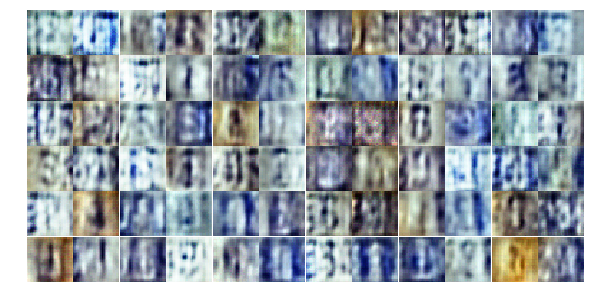

Epoch 3/10... Discriminator Loss: 0.8139... Generator Loss: 0.9944
Epoch 3/10... Discriminator Loss: 1.1556... Generator Loss: 1.5692
Epoch 3/10... Discriminator Loss: 0.7453... Generator Loss: 1.4844
Epoch 3/10... Discriminator Loss: 0.7180... Generator Loss: 1.4866
Epoch 3/10... Discriminator Loss: 2.0984... Generator Loss: 0.2147
Epoch 3/10... Discriminator Loss: 0.8045... Generator Loss: 1.1077
Epoch 3/10... Discriminator Loss: 1.1982... Generator Loss: 0.5812
Epoch 3/10... Discriminator Loss: 0.8080... Generator Loss: 0.9691
Epoch 3/10... Discriminator Loss: 1.5380... Generator Loss: 4.1303
Epoch 3/10... Discriminator Loss: 1.0293... Generator Loss: 0.8246


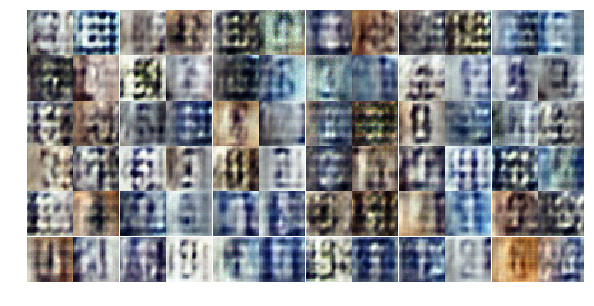

Epoch 3/10... Discriminator Loss: 1.0969... Generator Loss: 1.2720
Epoch 3/10... Discriminator Loss: 1.2103... Generator Loss: 0.5715
Epoch 3/10... Discriminator Loss: 0.8239... Generator Loss: 1.0392
Epoch 3/10... Discriminator Loss: 0.5207... Generator Loss: 1.8014
Epoch 3/10... Discriminator Loss: 0.6319... Generator Loss: 1.2712
Epoch 3/10... Discriminator Loss: 0.7865... Generator Loss: 2.2156
Epoch 3/10... Discriminator Loss: 0.7101... Generator Loss: 1.1309
Epoch 3/10... Discriminator Loss: 0.8828... Generator Loss: 1.4857
Epoch 3/10... Discriminator Loss: 1.2162... Generator Loss: 0.5714
Epoch 3/10... Discriminator Loss: 0.5396... Generator Loss: 1.9122


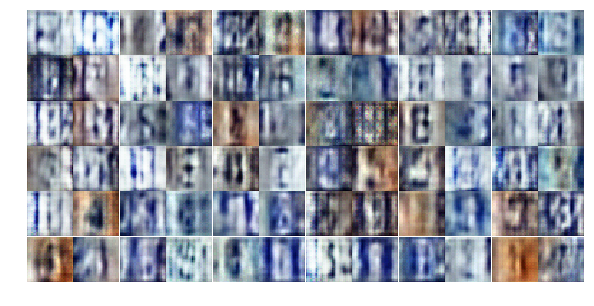

Epoch 3/10... Discriminator Loss: 0.9556... Generator Loss: 0.9837
Epoch 3/10... Discriminator Loss: 0.5973... Generator Loss: 1.3831
Epoch 3/10... Discriminator Loss: 0.9444... Generator Loss: 1.5158
Epoch 3/10... Discriminator Loss: 1.2894... Generator Loss: 2.7658
Epoch 3/10... Discriminator Loss: 0.9240... Generator Loss: 1.8062
Epoch 3/10... Discriminator Loss: 0.7569... Generator Loss: 1.5707
Epoch 3/10... Discriminator Loss: 0.7147... Generator Loss: 1.2952
Epoch 3/10... Discriminator Loss: 0.7479... Generator Loss: 3.5860
Epoch 3/10... Discriminator Loss: 0.6949... Generator Loss: 1.1680
Epoch 3/10... Discriminator Loss: 0.6994... Generator Loss: 1.1457


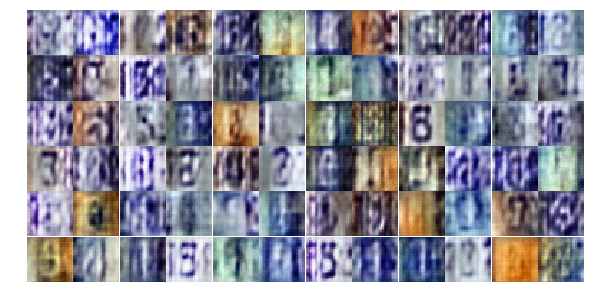

Epoch 3/10... Discriminator Loss: 0.5435... Generator Loss: 1.4488
Epoch 3/10... Discriminator Loss: 0.5434... Generator Loss: 2.1797
Epoch 3/10... Discriminator Loss: 1.0543... Generator Loss: 1.0530
Epoch 3/10... Discriminator Loss: 0.8875... Generator Loss: 0.8154
Epoch 3/10... Discriminator Loss: 0.5938... Generator Loss: 1.6859
Epoch 3/10... Discriminator Loss: 1.1634... Generator Loss: 0.5699
Epoch 3/10... Discriminator Loss: 0.5080... Generator Loss: 1.6935
Epoch 3/10... Discriminator Loss: 0.5443... Generator Loss: 1.4869
Epoch 3/10... Discriminator Loss: 0.4783... Generator Loss: 1.9113
Epoch 3/10... Discriminator Loss: 0.8068... Generator Loss: 1.2978


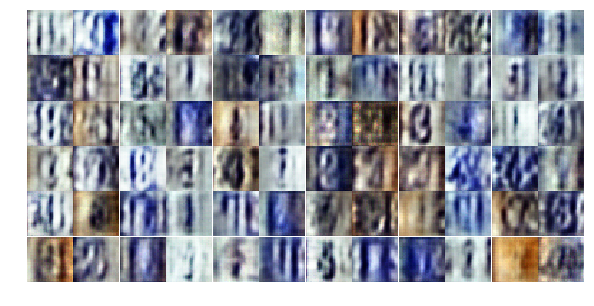

Epoch 3/10... Discriminator Loss: 0.6340... Generator Loss: 1.4504
Epoch 3/10... Discriminator Loss: 0.7030... Generator Loss: 1.4464
Epoch 3/10... Discriminator Loss: 0.8736... Generator Loss: 2.0970
Epoch 3/10... Discriminator Loss: 0.3765... Generator Loss: 1.9943
Epoch 3/10... Discriminator Loss: 0.8830... Generator Loss: 1.8026
Epoch 3/10... Discriminator Loss: 0.3949... Generator Loss: 1.9559
Epoch 3/10... Discriminator Loss: 0.8478... Generator Loss: 0.9176
Epoch 3/10... Discriminator Loss: 0.5713... Generator Loss: 1.6906
Epoch 3/10... Discriminator Loss: 0.6496... Generator Loss: 1.9698
Epoch 3/10... Discriminator Loss: 0.8243... Generator Loss: 1.2394


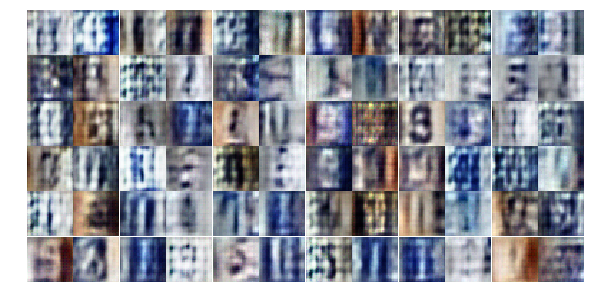

Epoch 3/10... Discriminator Loss: 1.4348... Generator Loss: 0.4434
Epoch 4/10... Discriminator Loss: 0.7406... Generator Loss: 1.2612
Epoch 4/10... Discriminator Loss: 0.6917... Generator Loss: 1.3878
Epoch 4/10... Discriminator Loss: 0.7911... Generator Loss: 0.9362
Epoch 4/10... Discriminator Loss: 0.7258... Generator Loss: 1.1678
Epoch 4/10... Discriminator Loss: 0.7895... Generator Loss: 1.3951
Epoch 4/10... Discriminator Loss: 0.6793... Generator Loss: 1.6662
Epoch 4/10... Discriminator Loss: 0.8046... Generator Loss: 0.9050
Epoch 4/10... Discriminator Loss: 0.5905... Generator Loss: 2.8487
Epoch 4/10... Discriminator Loss: 1.0753... Generator Loss: 0.6097


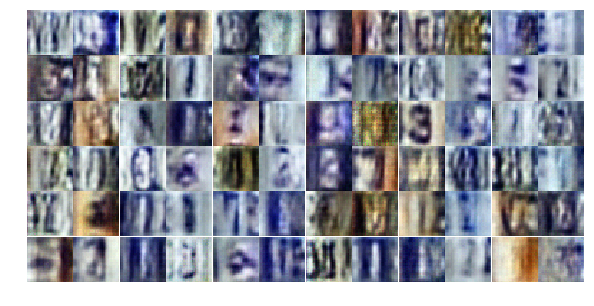

Epoch 4/10... Discriminator Loss: 0.7241... Generator Loss: 1.2440
Epoch 4/10... Discriminator Loss: 0.5808... Generator Loss: 1.4638
Epoch 4/10... Discriminator Loss: 1.1579... Generator Loss: 0.9636
Epoch 4/10... Discriminator Loss: 1.4075... Generator Loss: 0.4652
Epoch 4/10... Discriminator Loss: 0.7744... Generator Loss: 1.7874
Epoch 4/10... Discriminator Loss: 1.9896... Generator Loss: 0.2365
Epoch 4/10... Discriminator Loss: 0.8788... Generator Loss: 1.4082
Epoch 4/10... Discriminator Loss: 0.6020... Generator Loss: 1.4156
Epoch 4/10... Discriminator Loss: 0.9650... Generator Loss: 1.1145
Epoch 4/10... Discriminator Loss: 0.9444... Generator Loss: 1.8273


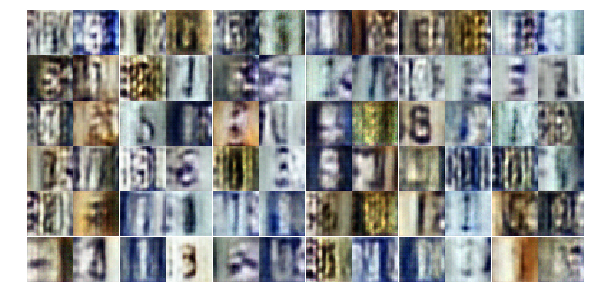

Epoch 4/10... Discriminator Loss: 0.6161... Generator Loss: 1.4561
Epoch 4/10... Discriminator Loss: 0.8381... Generator Loss: 1.9842
Epoch 4/10... Discriminator Loss: 0.7834... Generator Loss: 1.0477
Epoch 4/10... Discriminator Loss: 0.7992... Generator Loss: 0.9312
Epoch 4/10... Discriminator Loss: 0.5363... Generator Loss: 1.6973
Epoch 4/10... Discriminator Loss: 1.1959... Generator Loss: 1.8997
Epoch 4/10... Discriminator Loss: 0.7213... Generator Loss: 1.2365
Epoch 4/10... Discriminator Loss: 0.6347... Generator Loss: 1.3341
Epoch 4/10... Discriminator Loss: 0.6765... Generator Loss: 1.4281
Epoch 4/10... Discriminator Loss: 0.5547... Generator Loss: 1.3087


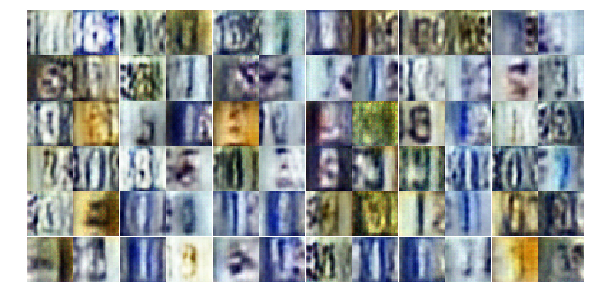

Epoch 4/10... Discriminator Loss: 0.7335... Generator Loss: 1.8603
Epoch 4/10... Discriminator Loss: 0.9722... Generator Loss: 1.9269
Epoch 4/10... Discriminator Loss: 0.6957... Generator Loss: 1.3246
Epoch 4/10... Discriminator Loss: 0.6284... Generator Loss: 1.5380
Epoch 4/10... Discriminator Loss: 0.4844... Generator Loss: 1.6967
Epoch 4/10... Discriminator Loss: 1.1890... Generator Loss: 2.0128
Epoch 4/10... Discriminator Loss: 0.7862... Generator Loss: 1.2451
Epoch 4/10... Discriminator Loss: 0.8575... Generator Loss: 1.1096
Epoch 4/10... Discriminator Loss: 0.4165... Generator Loss: 1.6463
Epoch 4/10... Discriminator Loss: 0.7568... Generator Loss: 1.4250


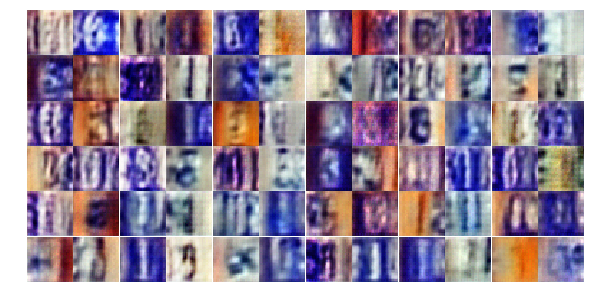

Epoch 4/10... Discriminator Loss: 1.0158... Generator Loss: 0.8431
Epoch 4/10... Discriminator Loss: 0.6350... Generator Loss: 1.6788
Epoch 4/10... Discriminator Loss: 0.6417... Generator Loss: 1.5674


KeyboardInterrupt: 

In [17]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))